# Getting Started

## Preparing a radiative transfer object

After installation has finished, let's try to calculate a first spectrum!
You can simply load petitRADTRANS by typing:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from petitRADTRANS.radtrans import Radtrans
from petitRADTRANS import physical_constants as cst


Let's start out by creating a radiative transfer object using the Radtrans class.

This will create an object ready to calculate spectra once the atmospheric parameters (temperature, abundances, mean molecular weight etc.) are set. 

Here we asked for the following molecular or atomic line absorbers to be inlcuded: $\rm H_2O$, $\rm CO$,  $\rm CH_4$, $\rm CO_2$, $\rm Na$, and $\rm K$.
The default opacity sources are set in the petitRADTRANS configuration file, ``.petitradtrans/petitradtrans_config_file.ini``, which is stored in your home directory. If you have not already set these, you will be asked to the first time you initialise a Radtrans object.

However, if you want more control over your opacity sources, additional tags such as ``__HITEMP`` or ``__Allard`` can be used to specify the opacity source or ``.R300`` to specify the spectral resolution. Identifiers stand for different line lists, or line broadening treatments (see ["Available opacity species"](../available_opacities.html)).
Additionally, the Rayleigh scattering cross-sections for $\rm H_2$ and $\rm He$ were loaded, as well as the collision induced absorption (CIA) cross-sections for the $\rm H_2$-$\rm H_2$ and $\rm H_2$-$\rm He$ pairs. The wavelength range that was loaded for the opacities here extends from 0.3 to 15 microns.

Note that the pressures **must** always be sorted in increasing order, and be equidistant in log-space. The pressure is in units of **bar**, although all other units in *petitRADTRANS* are in cgs. Typically we reccommend using around 100 layers in your computations. However, be careful, internally pRT converts the pressure to cgs units!

In [2]:
atmosphere = Radtrans(pressures = np.logspace(-6,2,100),
                      line_species = ['H2O', 
                                      'CO-NatAbund', 
                                      'CH4', 
                                      'CO2', 
                                      'Na',
                                      'K'],
                      rayleigh_species = ['H2', 'He'],
                      gas_continuum_contributors = ['H2-H2', 'H2-He'],
                      wavelength_boundaries = [0.3, 15])

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k/Na/23Na/

/Users/nasedkin/testing/petitRADTRANS/petitRADTRANS/_input_data_loader.py:216: UserWarning: file 'temps.dat' lack spectral information (resolution: , range: )
  warnings.warn(f"file '{file}' lack spectral information "
/Users/nasedkin/testing/petitRADTRANS/petitRADTRANS/_input_data_loader.py:216: UserWarning: file 'CIA_H2-H2_final.dat' lack spectral information (resolution: , range: )
  warnings.warn(f"file '{file}' lack spectral information "
/Users/nasedkin/testing/petitRADTRANS/petitRADTRANS/_input_data_loader.py:216: UserWarning: file 'CIA_H2-He_final.dat' lack spectral information (resolution: , range: )
  warnings.warn(f"file '{file}' lack spectral information "


And we are done! These steps only need to be carried out once, after this we are free to play with this radiative transfer object, for example change the temperature, abundances, etc. Only if additional opacity species need to be loaded is it necessary to create a new Radtrans instance.

<div class="alert alert-warning">

**Units in petitRADTRANS:** all units in *petitRADTRANS* are in cgs, **except for pressure**, which is in bars, **and the mean molecular weight (MMW)**, which is in units of atomic mass units.
</div>

## Calculating a transmission spectrum

Let's calculate a first spectrum for a hot Jupiter, first in transmission. Let's assume an isothermal temperature profile, for now. We start by specifing the temperature array, and abundance dictionery, containing the mass fractions of the atmospheric material, at every layer, and the atmospheric mean molecular weight, at every layer, in units of amu:

In [3]:
temperatures = 1200. * np.ones_like(atmosphere.pressures)

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperatures)
mass_fractions['He'] = 0.24 * np.ones_like(temperatures)
mass_fractions['H2O'] = 1e-3 * np.ones_like(temperatures)
mass_fractions['CO-NatAbund'] = 1e-2 * np.ones_like(temperatures)
mass_fractions['CO2'] = 1e-4 * np.ones_like(temperatures)
mass_fractions['CH4'] = 1e-5 * np.ones_like(temperatures)
mass_fractions['Na'] = 1e-4 * np.ones_like(temperatures)
mass_fractions['K'] = 1e-6 * np.ones_like(temperatures)

mean_molecular_weight = 2.33 * np.ones_like(temperatures)

**Note that these are freely made up values, however. The P-T profile of a real planet may well be different, and not isothermal. Also the abundances are just made up for this simple example here** (see ["Interpolating chemical equilibrium abundances"](poor_man.html) for how to improve this.)

<div class="alert alert-warning">

**Abundances in petitRADTRANS:** abundances in pRT are in units of **mass fractions**, not number fractions (aka volume mixing ratio, VMR). You can convert between mass fractions and VMRs by using
\begin{equation}
X_i = \frac{\mu_i}{\mu}n_i,
\end{equation}
where $X_i$ is the mass fraction of species $i$, $\mu_i$ the mass of a single molecule/atom/ion/... of species $i$, $\mu$ is the atmospheric mean molecular weight, and $n_i$ is the VMR of species $i$.

</div>

Next, let's assume a planetary radius and gravity at a given pressure $P_0=0.01$ bar in the atmosphere, and we are all set!

In [4]:
planet_radius = 1.0*cst.r_jup_mean
gravity = 10**4.0
reference_pressure = 0.01

Now we simply generate a transmission spectrum. The ``calculate_transit_radii`` returns wavelengths in cm and transit radius in cm, as well as a dictionary of additional optional outputs.

In [5]:
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molecular_weight, 
                                                                   reference_gravity=gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure)

Let's plot the transit radius!

Text(0, 0.5, 'Transit radius [$\\rm R_{Jup}$]')

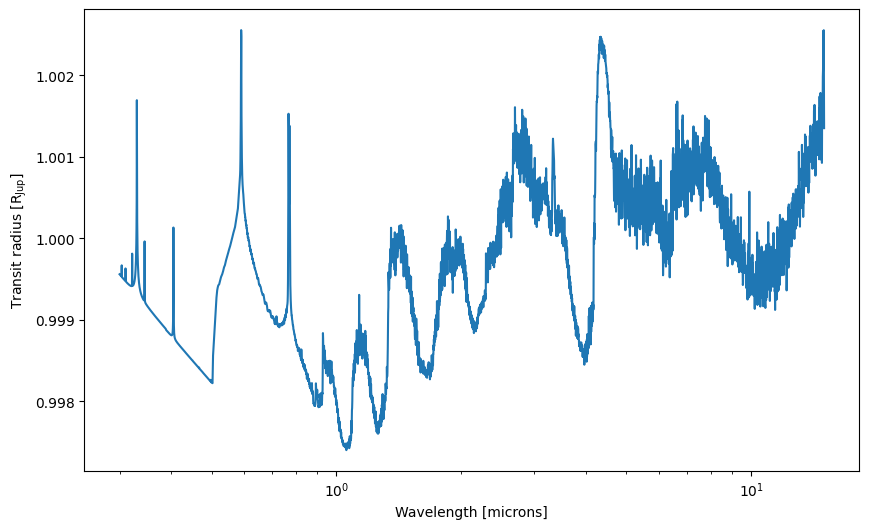

In [6]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths*1e4, transit_radii/cst.r_jup_mean)
ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit radius [$\rm R_{Jup}$]')

## Calculating an emission spectrum

<div class="alert alert-warning">

**Scattering and petitRADTRANS:** scattering is included for emission spectra in petitRADTRANS only if requested specifically when generating the Radtrans object, as it increases the runtime (see ["Scattering for Emission Spectra"](emis_scat.html) for an example how to do this). We neglect the scattering here.

</div>

Let's calculate an emission spectrum. Using an isothermal temperature structure as above would simply result in a black body spectrum.
pRT returns all spectra in cgs units at the surface of the emission source.

Text(0, 0.5, 'Planet flux, $F_{\\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

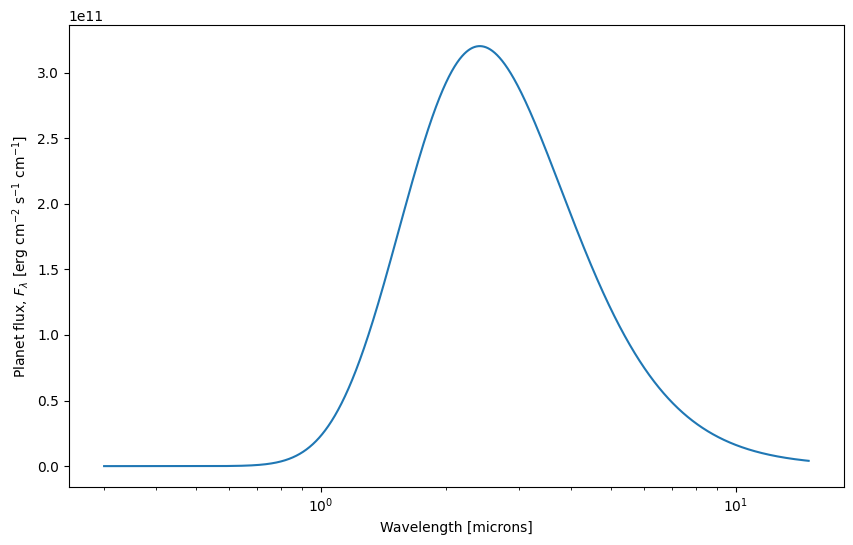

In [7]:
wavelengths, flux, _ = atmosphere.calculate_flux(temperatures=temperatures, 
                                                 mass_fractions=mass_fractions, 
                                                 mean_molar_masses = mean_molecular_weight,
                                                 reference_gravity = gravity)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths *1e4, flux)

plt.xscale('log')
ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Planet flux, $F_{\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')


So let's try something different instead, namely the often-used analytical atmospheric P-T profile from [Guillot (2010)](http://adsabs.harvard.edu/abs/2010A%26A...520A..27G), his Equation 29:

\begin{equation}
T^4 = \frac{3T_{\rm int}^4}{4}\left(\frac{2}{3}+\tau\right) + \frac{3T_{\rm equ}^4}{4}\left[\frac{2}{3}+\frac{1}{\gamma\sqrt{3}}+\left(\frac{\gamma}{\sqrt{3}}-\frac{1}{\gamma\sqrt{3}}\right)e^{-\gamma\tau\sqrt{3}}\right]
\end{equation}

with $\tau = P\kappa_{\rm IR}/g$. Here, $\tau$ is the optical depth, $P$ the pressure, $\kappa_{\rm IR}$ is the atmospheric opacity in the IR wavelengths (i.e. the cross-section per unit mass), $\gamma$ is the ratio between the optical and IR opacity, $T_{\rm equ}$ the atmospheric equilibrium temperature, and $T_{\rm int}$ is the planetary internal temperature.

In [8]:
from petitRADTRANS.physics import temperature_profile_function_guillot_global
pressures_bar = atmosphere.pressures*1e-6 # cgs to bar
kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.

temperatures = temperature_profile_function_guillot_global(pressures_bar, kappa_IR, gamma, gravity, T_int, T_equ)

Let's plot the P-T profile:

Text(0, 0.5, 'P [bar]')

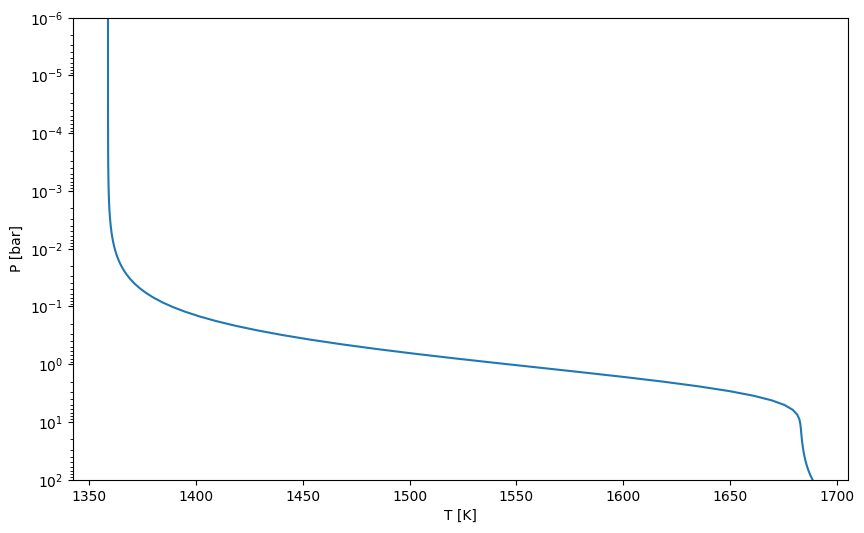

In [9]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(temperatures, pressures_bar)
ax.set_yscale('log')
ax.set_ylim([1e2, 1e-6])
ax.set_xlabel('T [K]')
ax.set_ylabel('P [bar]')


An recalculate the spectrum:

Text(0, 0.5, 'Planet flux, $F_{\\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

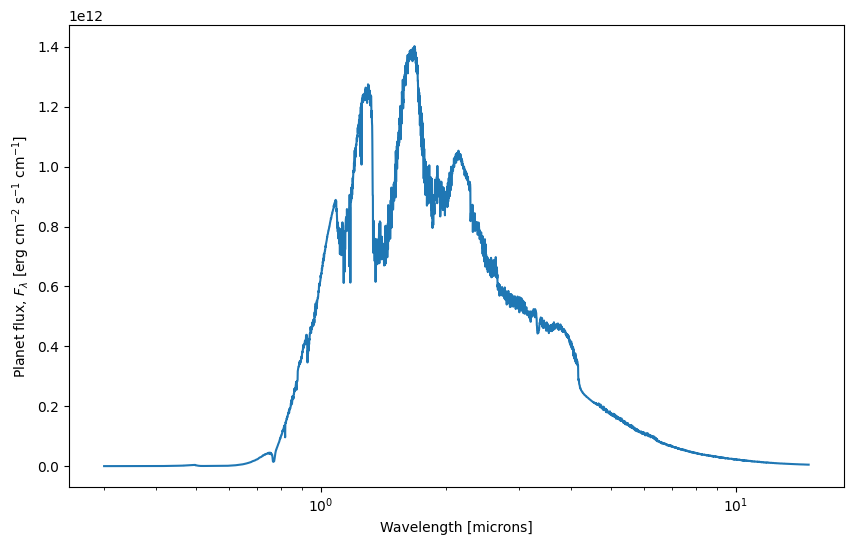

In [11]:
wavelengths, flux, _ = atmosphere.calculate_flux(temperatures=temperatures, 
                                                 mass_fractions=mass_fractions, 
                                                 mean_molar_masses = mean_molecular_weight,
                                                 reference_gravity = gravity)
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths*1e4, flux)

plt.xscale('log')
ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Planet flux, $F_{\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')